# Alpha Notebook Results

The following notebooks presents results for the Alpha version of the project. Please note that, contrary to what was decided earlier, comparison between DFA and Backprop has been moved to Beta.

## Import Dependencies

In [89]:
import torch
import copy
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import numpy as np
from scipy.special import expit

## Simple ANN Torch Model

In [90]:
class DynamicModel(nn.Module):
    def __init__(self, layer_sizes, act_function):
        super(DynamicModel, self).__init__()
        # Define layers using ModuleList
        self.layers = nn.ModuleList(
            [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]
        )
        self.act_function = act_function  # Activation function

    def forward(self, x):
        # Forward pass through each layer
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Apply activation to all except the last layer
            if i < len(self.layers) - 1:
                x = self.act_function(x)
        return x

## Forward and Backward pass using DFA

In [91]:

# Forward pass using PyTorch model
def forward_pass(model, x):
    h1 = model.act_function(model.layers[0](x))
    a1 = model.layers[0](x)
    a2 = model.layers[1](h1)
    y_hat = torch.sigmoid(a2)
    return a1, h1, a2, y_hat

# DFA backward pass with PyTorch tensors
def dfa_backward_pass(e, h1, B1, a1, x):
    dW2 = -torch.matmul(e, h1.T)
    da1 = torch.matmul(B1, e) * (1 - torch.tanh(a1) ** 2) # tanh derivative
    dW1 = -torch.matmul(da1, x.T)
    db1 = -torch.sum(da1, dim=1, keepdim=True)
    db2 = -torch.sum(e, dim=1, keepdim=True)
    return dW1, dW2, db1, db2

## Training loop using Direct Feedback Alignment

In [92]:
def train_DFA(model, x, y, n_epochs=10, lr=1e-3, batch_size=200, tol=1e-1):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Initialize random feedback matrix
    B1 = torch.randn(model.layers[0].out_features, model.layers[-1].out_features)

    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    angles = []
    te_dfa = []
    loss_dfa = []

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        train_error = 0

        for batch_x, batch_y in dataloader:
            # Forward pass
            a1, h1, a2, y_hat = forward_pass(model, batch_x)
            error = y_hat - batch_y
            preds = torch.argmax(y_hat, dim=1)
            truth = torch.argmax(batch_y, dim=1)
            train_error += (preds != truth).sum().item()

            # Calculate loss
            loss_on_batch = F.binary_cross_entropy(y_hat, batch_y)
            epoch_loss += loss_on_batch.item()

            # DFA backward pass
            dW1, dW2, db1, db2 = dfa_backward_pass(error.T, h1.T, B1, a1.T, batch_x.T)

            # Update weights manually
            with torch.no_grad():
                model.layers[0].weight += lr * dW1
                model.layers[0].bias += lr * db1.squeeze()
                model.layers[1].weight += lr * dW2
                model.layers[1].bias += lr * db2.squeeze()

        training_error = train_error / len(dataset)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(dataloader):.4f}, Training Error = {training_error:.4f}")

        prev_training_error = te_dfa[-1] if te_dfa else 0
        if np.abs(training_error - prev_training_error) <= tol:
            te_dfa.append(training_error)
            print(f'Hitting tolerance of {tol} with {np.abs(training_error - prev_training_error)}')
            break
        te_dfa.append(training_error)
        loss_dfa.append(epoch_loss)

    return te_dfa, loss_dfa, angles

## Training loop using PyTorch's Backpropagation

In [93]:
def train_BACK(model, x, y, n_epochs=10, lr=1e-3, batch_size=32, tol=1e-4):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Create DataLoader for batch processing
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()  # Replace with appropriate loss for your task

    # Training loop
    train_errors = []
    epoch_losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        train_error = 0.0
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            preds = torch.argmax(outputs, dim=1)
            truth = torch.argmax(batch_y, dim=1)
            train_error += (preds != truth).sum().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate batch loss
            epoch_loss += loss.item() * batch_X.size(0)

        # Average epoch loss
        epoch_loss /= len(batch_X)
        train_error /= len(batch_X)
        epoch_losses.append(epoch_loss)
        train_errors.append(train_error)

        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

        # Early stopping criterion
        if len(train_errors) > 1 and abs(train_errors[-2] - train_errors[-1]) < tol:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_errors, epoch_losses

## Solving MNIST

In [94]:
# Dataset stuff 
# # ======================== MNIST ============================
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255.0
X_test /= 255.0
X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)
nb_classes = 10
y_train = np.eye(nb_classes)[y_train]
y_test = np.eye(nb_classes)[y_test]
# # ======================== MNIST ============================

# Define the model
input_size = 784 #784
hidden_size = 200 #800
output_size = 10 #10
epochs = 80
batch_size = 200
learning_rate = 1e-4
act_function = nn.Tanh()

model_DFA = DynamicModel([input_size, hidden_size, output_size], act_function)
model_BACK = copy.deepcopy(model_DFA)

# Train the model using DFA
te_dfa, loss_dfa, angles = train_DFA(model_DFA, X_train, y_train, n_epochs=epochs, lr=learning_rate, batch_size=batch_size, tol = -1)

# Train using Backprop
# error with the loss on this one /shrug
te_back, loss_back = train_BACK(model_BACK, X_train, y_train, n_epochs=epochs, lr=learning_rate, batch_size=batch_size, tol=-1)

Epoch 1: Loss = 0.1614, Training Error = 0.2245
Epoch 2: Loss = 0.0787, Training Error = 0.1055
Epoch 3: Loss = 0.0652, Training Error = 0.0919
Epoch 4: Loss = 0.0584, Training Error = 0.0834
Epoch 5: Loss = 0.0539, Training Error = 0.0766
Epoch 6: Loss = 0.0505, Training Error = 0.0716
Epoch 7: Loss = 0.0477, Training Error = 0.0678
Epoch 8: Loss = 0.0454, Training Error = 0.0649
Epoch 9: Loss = 0.0434, Training Error = 0.0622
Epoch 10: Loss = 0.0417, Training Error = 0.0593
Epoch 11: Loss = 0.0402, Training Error = 0.0570
Epoch 12: Loss = 0.0388, Training Error = 0.0551
Epoch 13: Loss = 0.0376, Training Error = 0.0526
Epoch 14: Loss = 0.0364, Training Error = 0.0514
Epoch 15: Loss = 0.0354, Training Error = 0.0495
Epoch 16: Loss = 0.0344, Training Error = 0.0479
Epoch 17: Loss = 0.0335, Training Error = 0.0468
Epoch 18: Loss = 0.0327, Training Error = 0.0452
Epoch 19: Loss = 0.0319, Training Error = 0.0442
Epoch 20: Loss = 0.0312, Training Error = 0.0435
Epoch 21: Loss = 0.0305, Trai

## Training error plots

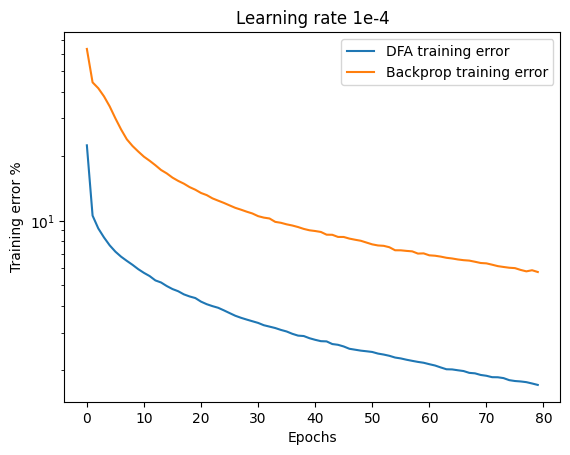

In [95]:
# Plot 
import matplotlib.pyplot as plt
plt.plot(range(len(te_dfa)), [i*100 for i in te_dfa], label='DFA training error')
plt.plot(range(len(te_back)), te_back, label='Backprop training error')
plt.title('Learning rate 1e-4')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Training error %')
plt.legend(loc='best')
plt.show()


## Testing Networks

In [96]:
# Test model
nb_dat = len(X_test)


found_dfa = 0
for index in range(nb_dat):
    X = torch.tensor(X_test[index], dtype=torch.float32)
    pred_DFA = model_DFA(X)

    predicted_val = np.argmax(pred_DFA.detach().numpy())
    expected_val = np.argmax(y_test[index])
    if expected_val == predicted_val:
        found_dfa += 1


found_back = 0
for index in range(nb_dat):
    X = torch.tensor(X_test[index], dtype=torch.float32)
    pred_BACK = model_BACK(X)

    predicted_val = np.argmax(pred_BACK.detach().numpy())
    expected_val = np.argmax(y_test[index])
    if expected_val == predicted_val:
        found_back += 1


print(f'DFA  : Nb dat : {nb_dat}\t found : {found_dfa}\t Accuracy : {found_dfa/nb_dat}')
print(f'BACK : Nb dat : {nb_dat}\t found : {found_back}\t Accuracy : {found_back/nb_dat}')
print(f'DFA/BACK efficency : {found_dfa/found_back*100:.2f}%')


DFA  : Nb dat : 10000	 found : 9723	 Accuracy : 0.9723
BACK : Nb dat : 10000	 found : 9724	 Accuracy : 0.9724
DFA/BACK efficency : 99.99%


## Confusion matrix

Confusion Matrix for DFA model
[[ 970    0    0    1    0    3    4    1    1    0]
 [   0 1122    2    1    0    1    5    1    3    0]
 [   6    1 1001    1    4    1    3    9    6    0]
 [   1    0    5  984    0    3    0    6    6    5]
 [   1    0    5    1  952    1    3    2    2   15]
 [   5    1    1    9    0  862    7    1    5    1]
 [   8    3    1    1    2    5  935    0    3    0]
 [   2    6   13    3    0    1    0  993    1    9]
 [   4    3    4    4    4    5    3    3  942    2]
 [   5    6    0    9   11    2    1    8    5  962]] 0.9719


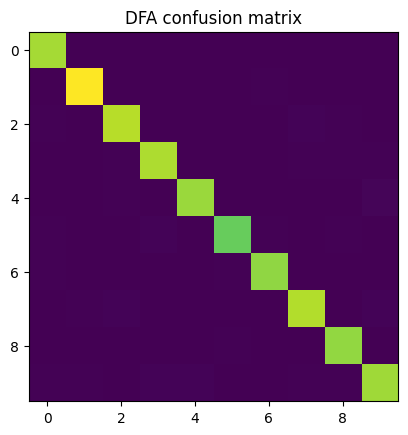

Confusion Matrix for BACK model
[[ 970    0    0    2    0    2    2    1    3    0]
 [   0 1122    2    1    0    1    5    1    3    0]
 [   4    1 1001    3    3    0    1    8    9    2]
 [   1    0    5  984    0    5    0    5    8    2]
 [   1    0    3    0  955    0    5    0    2   16]
 [   5    0    0   10    1  861    5    2    7    1]
 [   8    3    0    1    2    7  931    0    6    0]
 [   1    6   15    1    1    0    0  993    2    9]
 [   4    2    2    4    4    2    2    2  950    2]
 [   5    6    1    9   13    5    0    6    7  957]] 0.9724


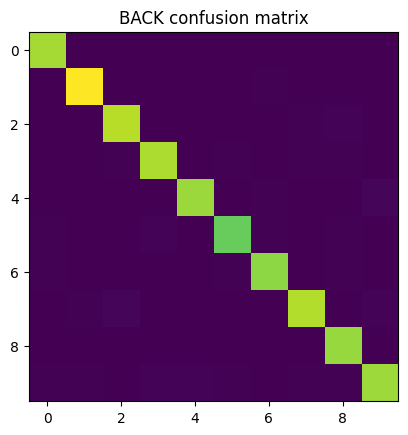

[[ 0  0  0 -1  0  1  2  0 -2  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0 -2  1  1  2  1 -3 -2]
 [ 0  0  0  0  0 -2  0  1 -2  3]
 [ 0  0  2  1 -3  1 -2  2  0 -1]
 [ 0  1  1 -1 -1  1  2 -1 -2  0]
 [ 0  0  1  0  0 -2  4  0 -3  0]
 [ 1  0 -2  2 -1  1  0  0 -1  0]
 [ 0  1  2  0  0  3  1  1 -8  0]
 [ 0  0 -1  0 -2 -3  1  2 -2  5]]


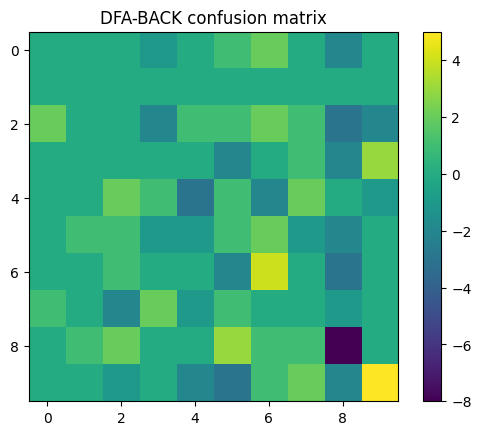

In [97]:

def compute_confusion_matrix_and_accuracy(model, X_test, y_test):
    num_classes = 10  # Number of classes in your dataset
    
    # Initialize the confusion matrix
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)
    
    # Initialize accuracy counter
    correct_predictions = 0
    
    with torch.no_grad():
        for index in range(len(X_test)):
            X = torch.tensor(X_test[index], dtype=torch.float32).unsqueeze(0)  # Add batch dimension if needed
            pred = model(X)
            

            predicted_val = np.argmax(pred.detach().numpy())
            expected_val = np.argmax(y_test[index])
            
            # print(conf_mat)

            # Update confusion matrix
            conf_mat[expected_val, predicted_val] += 1
            
            # Check if the prediction is correct
            if predicted_val == expected_val:
                correct_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / len(X_test)
    
    return conf_mat, accuracy



conf_mat_DFA, accuracy_DFA = compute_confusion_matrix_and_accuracy(model_DFA, X_test, y_test)
print("Confusion Matrix for DFA model")

if True:
    import matplotlib.pyplot as plt
    plt.imshow(conf_mat_DFA)
    plt.title("DFA confusion matrix")
    plt.show()




conf_mat_BACK, accuracy_BACK = compute_confusion_matrix_and_accuracy(model_BACK, X_test, y_test)
print("Confusion Matrix for BACK model")
print(conf_mat_BACK, accuracy_BACK)

if True:
    import matplotlib.pyplot as plt
    plt.imshow(conf_mat_BACK)
    plt.title("BACK confusion matrix")
    plt.show()





mat_dif = conf_mat_DFA-conf_mat_BACK
print(mat_dif)
if True:
    import matplotlib.pyplot as plt
    plt.imshow(mat_dif)
    plt.title("DFA-BACK confusion matrix")
    plt.colorbar()
    plt.show()


## Precision and recall

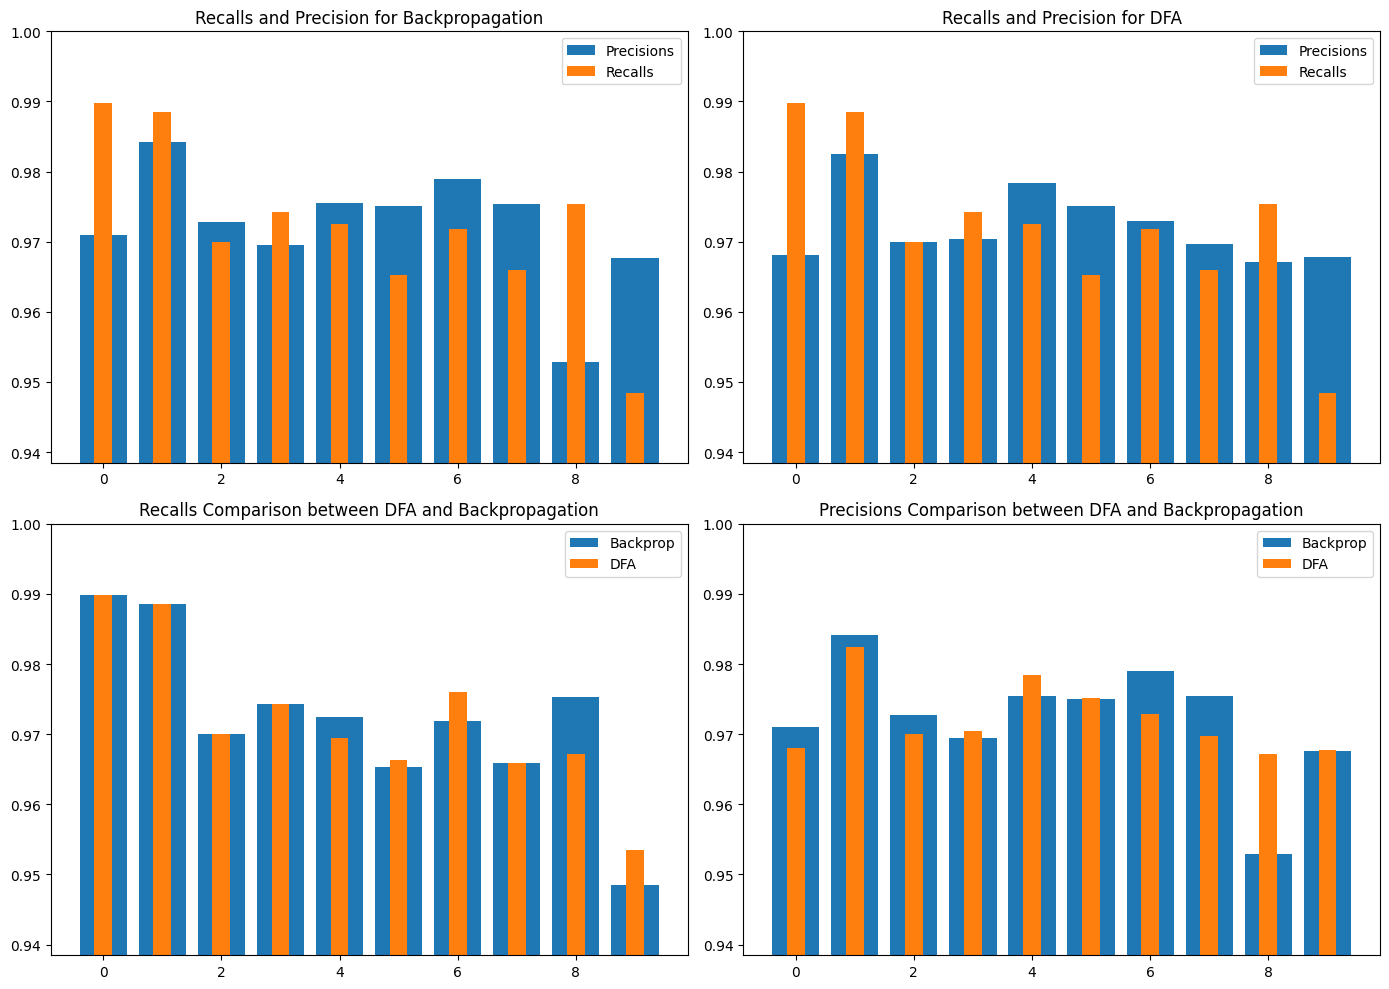

In [99]:
def compute_recall_and_precision(conf_matrix):
    num_classes = conf_matrix.shape[0]
    
    recalls = []
    precisions = []
    
    for i in range(num_classes):
        true_positives = conf_matrix[i, i]
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        
        if true_positives + false_negatives == 0:
            recall = np.nan  # Avoid division by zero if no actual positives in class
        else:
            recall = true_positives / (true_positives + false_negatives)
        
        if true_positives + false_positives == 0:
            precision = np.nan  # Avoid division by zero if no predicted positives in class
        else:
            precision = true_positives / (true_positives + false_positives)
        
        recalls.append(recall)
        precisions.append(precision)
    
    return recalls, precisions



lower_part = 0.94
second_width = 0.3



recalls_back, precisions_back = compute_recall_and_precision(conf_mat_BACK)
recalls_dfa, precisions_dfa = compute_recall_and_precision(conf_mat_DFA)

lower_part = max(min(min(recalls_back), min(recalls_dfa), min(precisions_back), min(precisions_dfa))-0.01, 0)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Recalls and Precision for Backpropagation
axes[0, 0].bar(range(len(precisions_back)), precisions_back, label="Precisions")
axes[0, 0].bar(range(len(recalls_back)), recalls_back, label="Recalls", width=second_width)
axes[0, 0].set_title("Recalls and Precision for Backpropagation")
axes[0, 0].legend()
axes[0, 0].set_ylim(lower_part, 1)

# Plot 2: Recalls and Precision for DFA
axes[0, 1].bar(range(len(precisions_dfa)), precisions_dfa, label="Precisions")
axes[0, 1].bar(range(len(recalls_dfa)), recalls_back, label="Recalls", width=second_width)
axes[0, 1].set_title("Recalls and Precision for DFA")
axes[0, 1].legend()
axes[0, 1].set_ylim(lower_part, 1)

# Plot 3: Recalls Comparison between DFA and Backpropagation
axes[1, 0].bar(range(len(recalls_back)), recalls_back, label="Backprop")
axes[1, 0].bar(range(len(recalls_dfa)), recalls_dfa, label="DFA", width=second_width)
axes[1, 0].set_title("Recalls Comparison between DFA and Backpropagation")
axes[1, 0].legend()
axes[1, 0].set_ylim(lower_part, 1)

# Plot 4: Precisions Comparison between DFA and Backpropagation
axes[1, 1].bar(range(len(precisions_back)), precisions_back, label="Backprop")
axes[1, 1].bar(range(len(precisions_dfa)), precisions_dfa, label="DFA", width=second_width)
axes[1, 1].set_title("Precisions Comparison between DFA and Backpropagation")
axes[1, 1].legend()
axes[1, 1].set_ylim(lower_part, 1)

plt.tight_layout()  # Adjust the spacing between plots
plt.show()
